In [1]:
# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

- [12 사용자 정의 데이터셋, Transforms & Dataloader](https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html)
- 머신러닝 문제를 푸는 과정에서 데이터를 준비하는데 많은 노력이 필요함함
- PyTorch는 데이터를 불러오는 과정을 쉽게해주고, 또 잘 사용한다면 코드의 가독성도 보다 높여줄 수 있는 도구들을 제공함
- 이 튜토리얼에서 일반적이지 않은 데이터셋으로부터 데이터를 읽어오고 전처리하고 증가하는 방법을 알아볼 것임


- 이번 튜토리얼을 진행하기 위해 아래 패키지들을 설치하기
    - `scikit-image` : 이미지 I/O 와 변형을 위해 필요함
    - `pandas` : csv 파일 parsing을 보다 쉽게 해줌

In [5]:
pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 21.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 21.1 MB/s eta 0:00:0000:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

# 반응형 모드
plt.ion()

- 다룰 데이터셋은 아래 조건과 같은 landmark가 있는 얼굴사진

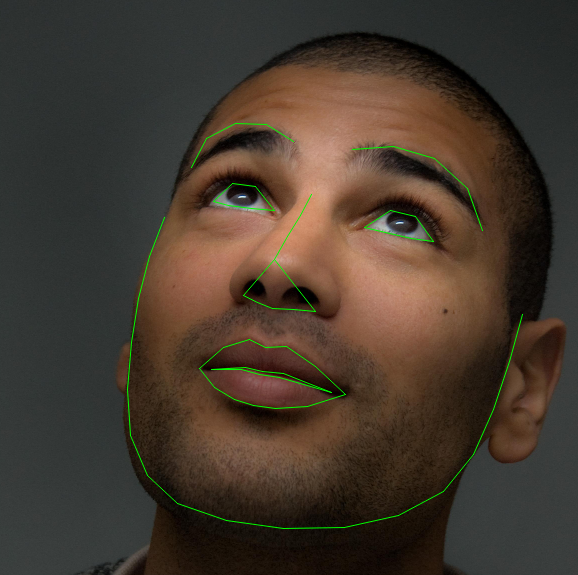

- 각각의 얼굴에 68개의 서로 다른 중요 포인트들이 존재함


데이터셋은 아래와 같은 특징을 가진 csv 파일이 포함되어 있음

In [ ]:
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

- 이제 CSV에서 이미지 이름과 그에 해당하는 데이터(annotation)을 가져와 볼 것임
- 예시로 `person-7.jpg`가 있는 65번째 줄(row index number)을 가져올 것임
- 이미지 이름을 읽어 img_name에 저장하고, 데이터는 (L, 2) 배열인 landmarks에 저장함
- 이 때 L은 해당 행의 랜드마크의 개수임

In [28]:
lm_df = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
lm_df.iloc[n:n+3]

img_name = lm_df.iloc[n, 0] # 'person-7.jpg'
landmarks = lm_df.iloc[n, 1:]
landmarks = np.asarray(landmarks) # (136,)
landmarks = landmarks.astype('float').reshape(-1, 2) # (68, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


이미지와 랜드마크를 보여주는 간단한 함수를 작성해보고, 실제로 적용해 볼 것임

<Figure size 432x288 with 0 Axes>

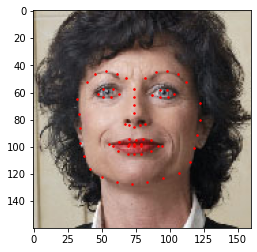

In [37]:
def show_landmarks(image, landmarks):
    '''Show image with landmarks'''
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
    plt.pause(0.001) # 갱신이 되도록 잠시 멈춤
    
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

# Dataset 클래스
- `torch.utils.data.Dataset`은 데이터셋을 나타내는 추상클래스
- 우리의 데이터셋은 `Dataset`에 상속하고 아래와 같이 override 해야 함


- `len(dataset)`에서 호출되는 `__len__`은 데이터셋의 크기를 return 해야 함
- `dataset[i]`에서 호출되는 `__getitem__`은 i번째 샘플을 찾는데 사용됨


- 이제 데이터셋 클래스를 만들어보자
- `__init__`을 사용해서 CSV 파일 안에 있는 데이터를 읽지만, `__getitem__`을 이용해서 이미지를 판독함
- 이 방법은 모든 이미지를 메모리에 저장하지 않고 필요할때마다 읽기 때문에 메모리를 효율적으로 사용함


- 데이터셋의 샘플은 `{'image': image, 'landmarks': landmarks}`의 사전 형태를 가짐
- 선택적 인자인 `transform`을 통해 필요한 전처리 과정을 샘플에 적용할 수 있음
- 다음 장에서 전이 `transform`의 유용성에 대해 알아볼 것임

In [82]:
class FaceLandmarksDataset(Dataset):
    '''Face Landmarks dataset'''
    
    def __init__(self, csv_file, root_dir, transform=None):
        '''
        Args:
            csv_file (string) : csv 파일의 경로
            root_dir (string) : 모든 이미지가 존재하는 디렉토리 경로
            transform (callable, optional) : 샘플에 적용될 optional transform
        '''
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        
        # idx가 tensor면 list로 형변환
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        
        # io.imread : image reading and writing
        image = io.imread(img_name)
        
        # idx번째의 데이터 가져와서 np.array로 형변환
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        
        # 형 변환 후 2열 형식(x, y)으로 reshape 
        landmarks = landmarks.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

- 클래스를 인스턴스화 하고 데이터 샘플을 통해서 반복해보자
- 첫번째 4개의 샘플의 크기를 출력하고, 샘플들의 랜드마크를 보여줄 것임

In [67]:
## **의 쓰임 : key, value를 받아줌
def test(**sample):
    for key, value in sample.items():
        print(key)
        print(value)
        break

test(**sample)

image
[[[  0   0   7]
  [  1   1   1]
  [  0   1   0]
  ...
  [  0   0   0]
  [  0   2   0]
  [  0   1   0]]

 [[  0   0   0]
  [162 164 153]
  [168 169 155]
  ...
  [145 147 144]
  [148 150 147]
  [  0   1   0]]

 [[  0   1   0]
  [165 166 152]
  [162 163 145]
  ...
  [143 148 142]
  [145 147 144]
  [  1   3   2]]

 ...

 [[  3   1   2]
  [ 80  56  30]
  [ 91  70  43]
  ...
  [ 45  59  68]
  [ 35  45  55]
  [  0   0   0]]

 [[  8   0   0]
  [ 88  70  56]
  [ 86  61  41]
  ...
  [ 28  46  58]
  [ 24  27  34]
  [  2   3   8]]

 [[  0   1   9]
  [  0   1   5]
  [  3   0   0]
  ...
  [  2   2   2]
  [  3   4   9]
  [  0   0   4]]]


idx 0 : (324, 215, 3) (68, 2)


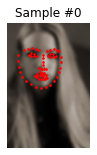

idx 1 : (500, 333, 3) (68, 2)


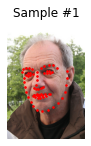

idx 2 : (250, 258, 3) (68, 2)


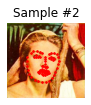

idx 3 : (434, 290, 3) (68, 2)


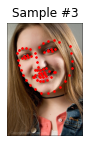

In [53]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')
fig = plt.figure()

# face_dataset은 image, landmarks의 정보를 담고 있음
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print('idx',i,':', sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    _ = ax.set_title('Sample #{}'.format(i))
    _ = ax.axis('off')
    show_landmarks(**sample) # (image, landmarks)
    
    if i == 3:
        plt.show()
        break

# Transforms
- 위에서 볼 수 있었던 한가지 문제점은 샘플들이 다 같은 크기가 아니라는 것
- 대부분의 신경망(neural networks)은 고정된 크기의 이미지라고 가정함
- 그러므로 우리는 신경망에 주기 전에 처리할 과정을 작성해야 함


- 3가지의 transforms를 만들어 보자
    - `Rescale` : 이미지의 크기를 조절함
    - `RandomCrop` : 이미지를 무작위로 자름 (data augmentation)
    - `ToTensor` : numpy 이미지에서 torch 이미지로 변경함 (축변환이 필요함)
    
    
- 간단한 함수 대신 호출할 수 있는 클래스로 작성함
- 이렇게 하면 클래스가 호출될 때마다 전이(Transform)의 매개변수가 전달되지 않아도 됨
- 이렇게 하려면 `__call__` 함수를 구현해야 함
- 필요하다면 `__init__`함수도..
- 다음과 같이 전이(transform)를 사용할 수 있음

In [ ]:
tsfm = Transform(params)
transformed_sample = tsfm(sample)

- 아래에서는 이미지와 랜드마크들을 어떻게 적용하는지 살펴보자

In [75]:
class Rescale(object):
    '''
    주어진 크기로 샘플 크기를 조정함
    
    Args:
        output_size(tuple or int) : 
        원하는 출력 크기가 tuple인 경우 해당 tuple(output_size)이 결과물(output)의 크기가 되고,
        int라면 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됨
    '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
    
        # self.output_size가 int라면..
        # 비율을 유지하면서, 길이가 작은 쪽이 output_size가 됨
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        
        # self.output_size가 tuple이라면..
        # 해당 tuple이 output_size가 됨 
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        
        # 밑에 코드는 crop이 아니라 픽셀값을 변경하는듯..?
        landmarks = landmarks * [new_w / w, new_h / h]
        
        return {'image' : img, 'landmarks' : landmarks}

class RandomCrop(object):
    '''
    샘플데이터를 무작위로 자름
    
    Args:
        output_size (tuple or int) : 줄이고자 하는 크기
                                     int라면, 정사각형으로 나올 것임
    '''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                     left: left + new_h]
        landmarks = landmarks - [left, top]
        
        return {'image' : image, 'landmarks' : landmarks}

class ToTensor(object):
    ''' numpy array를 tensor(torch)로 변환 시켜줌'''
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # swap color axis because
        # numpy image : H x W x C
        # torch image : C x H x W
        image = image.transpose((2, 0, 1))
        return {'image' : torch.from_numpy(image),
               'landmarks' : torch.from_numpy(landmarks)}

# Compose transforms
- 샘플에 전이(transform)를 적용해 보자
- 이미지의 가장 짧은 측면을 256개로 rescale하고, 그후에 무작위로 224개를 자른다고 가정함
- 다시말해, `Rescale`과 `RandomCrop`을 사용할 것임
- `torchvision.transforms.Compose`는 위의 두 작업을 하는 간단한 호출할 수 있는 클래스임

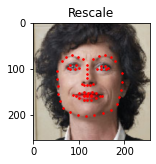

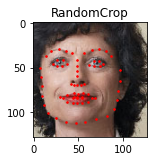

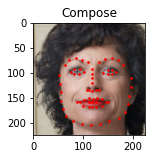

In [80]:
# 1) 이미지의 h, w 중 길이가 더 짧은 쪽이 256이 되고 본래 비율 유지
scale = Rescale(256)

# 2) 이미지를 줄이고자 하는 크기로 무작위로 자름
# int : 정사각형, tuple : 직사각형
crop = RandomCrop(128)

# 1) + 2)
composed = transforms.Compose([Rescale(256),
                             RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(1, 3, i+1)
    plt.tight_layout()
    _ = ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample) # annotation

plt.show()

# 데이터셋을 이용한 반복작업
- 전이(transform)를 적용한 dataset을 만들기 위해서 만들었던 것을 다 집어넣어 보자
- 요약하자면, 데이터셋은 다음과 같이 샘플링 됨
    - 이미지는 파일 전체를 메모리에 올리지 않고 필요할 때마다 불러와서 읽음
    - 그렇게 읽은 이미지에 `Transform`을 적용함
    - `transforms` 중 하나가 랜덤이기 때문에 데이터는 샘플링 때 증가함
- 우리는 for문을 이용하여 생성된 데이터셋을 반복 작업에 사용할 수 있음

In [113]:
# FaceLandmarksDataset - return sample ( = {'image': image, 'landmarks': landmarks} )
transformed_dataset = FaceLandmarksDataset(csv_file = 'data/faces/face_landmarks.csv',
                                          root_dir = 'data/faces',
                                          transform = transforms.Compose(
                                              [Rescale(256), RandomCrop(224), ToTensor()]))
fig = plt.figure()
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size())
    print(sample['image'].size(2))

    if i == 3:
        break
        
plt.show()

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
224
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
224
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
224
3 torch.Size([3, 224, 224]) torch.Size([68, 2])
224


<Figure size 432x288 with 0 Axes>

- 그러나 데이터 상에서 반복하는 for문은 많은 특징(features)을 놓칠 수 있음
- 특히 아래와 같은 것을 놓칠 수 있음
    - 데이터를 묶는 과정
    - 데이터를 섞는 과정
    - 병렬처리 과정에서 multiprocessing을 사용할 때 데이터를 불러오는 것
    
    
- `torch.utils.data.DataLoader`는 위와 같은 기능을 해주는 반복자(iterator)임
- 사용되는 매개변수(Parameters)는 명확해야 함
- `collate_fn`는 흥미로운 매개변수(Parameters) 중 하나임
- `collate_fn`을 이용하여 샘플들을 정확하게 배치하는 방법을 명시할 수 있음
- 그러나 대부분의 경우에 대해서 정확하게 작동해야 함

In [137]:
## sample_batched['image'].size(), sample_batched['landmars'].size() 확인용
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['landmarks'].size())
#     print(sample_batched['image'].size(2))
    
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']    
    grid = utils.make_grid(images_batch) 
    type(grid)
    grid.shape
    (grid.numpy().transpose((1, 2, 0))).shape
    type(grid.numpy())
    
     
    ''' >> (code) scatter parameter 
    픽셀값에 특정한 값을 더해준 것 같은데 왜? 그? 값을 썼는지?? '''
    
    batch_size = len(images_batch) # DataLoader에서 batch_size와 동일함
    im_size = images_batch.size(2) # .size() : (4, 3, 224, 224) / .size(2) : 224
    grid_border_size = 2
    for i in range(batch_size): # i = 0, 1, 2, 3, ...
        print((landmarks_batch[i, :, 0].numpy()).shape)
        print((landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size).shape)
        break
    
    break

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


torch.Tensor

torch.Size([3, 228, 906])

(228, 906, 3)

numpy.ndarray

' >> (code) scatter parameter \n    픽셀값에 특정한 값을 더해준 것 같은데 왜? 그? 값을 썼는지??'

(68,)
(68,)


"\ntransformed_dataset[i]['image'].shape = torch.Size([3, 224, 224])\ntransformed_dataset[i]['landmarks'].shape = torch.Size([68, 2])\n"

'\nbatch_size = 4개씩 묶어줌\n'

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


<Figure size 432x288 with 0 Axes>

(-0.5, 905.5, 227.5, -0.5)

4 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
6 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
7 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
8 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
9 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
10 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
11 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
12 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
13 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
14 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
15 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
16 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
17 torch.Size([1, 3, 224, 224]) torch.Size([1, 68, 2])


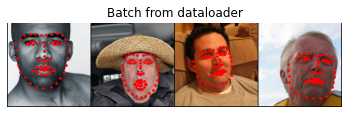

In [110]:
# FaceLandmarksDataset - return sample ( = {'image': image, 'landmarks': landmarks} )
# transformed_dataset : Rescale, RandomCrop된 상태로 return된 사전을 담고 있음
'''
transformed_dataset[i]['image'].shape = torch.Size([3, 224, 224])
transformed_dataset[i]['landmarks'].shape = torch.Size([68, 2])
'''

transformed_dataset = FaceLandmarksDataset(csv_file = 'data/faces/face_landmarks.csv',
                                          root_dir = 'data/faces',
                                          transform = transforms.Compose(
                                              [Rescale(256), RandomCrop(224), ToTensor()]))

dataloader = DataLoader(transformed_dataset, batch_size = 4,
                       shuffle = True, num_workers = 0)

# 배치하는 과정을 보여주는 함수
# sample_batched는 dataloader에서 for문 돌려서 지정한 batch_size만큼씩 받음
def show_landmarks_batch(sample_batched):
    '''Show image with landmarks for a batch of samples'''
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch) # DataLoader에서 batch_size와 동일함
    im_size = images_batch.size(2) # .size() : (4, 3, 224, 224) / .size(2) : 224
    grid_border_size = 2 # for what?
    
    '''
    utils.make_grid() : 이미지를 훈련시킬 때 중간중간 결과 확인을 위한 함수
    - 해당 함수에서 가장 중요한 것은 batch를 포함해서 4차원 데이터가 들어가야함
    - 그 이유는 여러 개의 이미지를 훈련시키면서 batch가 포함된 dataloader image tensor들이 
    있는 상황에서 도중에 보고자 할 때 사용하기 위한 목적성을 가진 함수이기 때문에!
    '''
    grid = utils.make_grid(images_batch) # grid.shape : (3, 228, 906) -> 이 숫자는 어디서 나온?
    plt.imshow(grid.numpy().transpose((1, 2, 0))) # shape : (228, 906, 3) -> 왜 transpose?
    
    ''' (code) scatter parameter '''
    for i in range(batch_size): # i = 0, 1, 2, 3, ...
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                   landmarks_batch[i, :, 1].numpy() + grid_border_size, s=10, marker='.', c='r')
        plt.title('Batch from dataloader')

# Windows를 사용 중이라면, 다음 줄의 주석을 제거하고 for 반복문을 들여쓰기
# 'num_workers'를 0으로 변경해야 할 수도 있음

# if __name__ == '__main__':
'''
batch_size = 4개씩 묶어줌
'''
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    
    # observe 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched) # 앞서 정의한 함수 이용
        plt.axis('off') # axis all deleted

# Afterword: torchvision
- 이번 튜토리얼에서는 데이터셋 작성과 사용, 전이(transforms), 데이터를 불러오는 방법에 대해서 알아봤음
- `torchvision` 패키지는 몇몇의 일반적인 데이터셋과 전이(transforms)들을 제공하기 때문에 클래스들을 따로 작성하지 않아도 될 것임
- `torchvision`에서의 사용가능한 일반적인 데이터셋 중 하나는 `ImageFolder`임
- 이것은 다음과 같은 방식으로 구성되어 있다고 가정함

In [ ]:
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png

- 여기서'ants', 'bees'는 class labels임
- 비슷하게 `RandomHorizontalFlip`, `Scale`과 같이 `PIL.Image`에서 작동하는 일반적인 전이(transforms)도 사용가능함
- 이와 같이 데이터로더(dataloader)를 사용할 수 있음

In [ ]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
     transforms.RandomSizedCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
 ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                        transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                          batch_size=4, shuffle=True,
                                          num_workers=4)

'''training code에 대한 예시를 알고 싶다면,
:doc:`transfer_learning_tutorial` 문서를 참고해주세요'''